In [1]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
def ClusterAndPlot(n_clusters, D):
    Labels = []
    
    print(D.shape)
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(D)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(D, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(D)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(D, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(D)
    gmmlabels_ = gmm.predict(D)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(D, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(D[:, 0], D[:, 1], cmap='viridis')
    axs[0, 0].set_title('Normal')

    axs[0, 1].scatter(D[:, 0], D[:, 1], c=gmmlabels_, cmap='viridis')
    axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(D[:, 0], D[:, 1], c=kmeans.labels_, cmap='viridis')
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(D[:, 0], D[:, 1], c=HC.labels_, cmap='viridis')
    axs[1, 1].set_title('HC')
    plt.show()
    
    Labels.append(HC.labels_)
    Labels.append(kmeans.labels_)
    Labels.append(gmmlabels_)
    return Labels


def pltPathologyClusters(labels):
    clusterimgDir = "../../Data/clusters_journal.PNG"
    image = Image.open(clusterimgDir) 
    plt.figure(figsize = (85,12))
    plt.imshow(image)
    plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    mseList = []
    valMse = []
    valSsim = []
    
    for cluster in sub_directories:
        direct = trainData + '/{}'.format(cluster)
#         if len(os.listdir(direct))-9 > 9: # if directory has less than 9 images set index to 0 else random index
#             index = np.random.randint(9,len(os.listdir(direct))-9)
#         else:
        index = 0 # pick the first 10 images
        clusterList = [] # reset the row
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                #image = Image.open(os.path.join(trainData, file)) 
                image = tifffile.imread(os.path.join(trainData, file))
                clusterList.append(image)
                displayImages.append(image) # list of ALL Images
        mseList.append(clusterList)
        
#         print(mseList)
#         print("Size of cluster {} is {}".format(str(cluster),len(os.listdir(direct))))
#         print("Taking images with the indices {} to {}\n".format(index, index+9))
    for clusterRow in mseList:
        SumMse = 0
        SumSsim = 0
        for i in range(0,7,2):
            val = compare_mse(clusterRow[i], clusterRow[i+1])
            valssim = ssim(clusterRow[i], clusterRow[i+1], multichannel=True)
            SumMse += val
            SumSsim += valssim
        valMse.append(math.ceil(SumMse / 4))
        valSsim.append(SumSsim / 4)
            
    
    fig = plt.figure(figsize=(14, 14))
    
    columns = 9
    rows = len(sub_directories)
    print(len(displayImages))
    print(columns*rows+1)
    for i in range(1, columns*rows+1):
        img = displayImages[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
#     plt.show()
    
    return [valMse, sum(valMse)/len(valMse),valSsim, sum(valSsim)/len(valSsim)]

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    directory = trainData
    sub_directories = [str(cluster) for cluster in set(labels)]
    
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])




In [3]:
## Data loading, and standardizing
trainData = "../../Data/train"

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData, filename)) 
        new_train.append(np.asarray( image, dtype="uint8" ))
        image_names.append(filename)

meanMatrix = np.asarray(new_train)
X = meanMatrix.reshape((len(new_train),-1))
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
# Evaluate regression
csvFilePath = "../../Data/regrData/train_labels.csv"
df = pd.read_csv(csvFilePath)
testlabels = []

for image in image_names:
    label_index = df[df["id"] == image.split(".")[0]].index[0]
    testlabels.append(df["label"][label_index])

In [5]:
autoencoder = load_model('../Autoencoders/SavedModels/new_mean_squared_error_epochs300_batch64.h5') # 6 x 6 x 16
autoencoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 96, 96, 16)   448         input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_154 (LeakyReLU)     (None, 96, 96, 16)   0           conv2d_109[0][0]                 
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 96, 96, 32)   4640        leaky_re_lu_154[0][0]            
___________________________________________________________________________________________

In [6]:
testlabels = np.asarray(testlabels)
meanMatrix = meanMatrix.astype('float32') / 255.
labels_pred = autoencoder.predict(meanMatrix)[1]
for i in range(len(labels_pred)):
    if labels_pred[i] < 0.5:
        labels_pred[i] = 0
    else:
        labels_pred[i] = 1
        
evaluation = metrics.classification_report(testlabels, labels_pred)
print(evaluation)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5996
           1       0.89      0.90      0.90      4003

    accuracy                           0.92      9999
   macro avg       0.91      0.91      0.91      9999
weighted avg       0.92      0.92      0.92      9999



In [7]:
layer_name = 'conv2d_115' # 6 x 6 x 32

intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)


(9999, 6, 6, 32)


(9999, 1152)
(9999, 1152)
HC Silhouette Score  0.037513215094804764 
kmeans Silhouette Score  0.08679021149873734 
gmm Silhouette Score  0.0899529904127121 


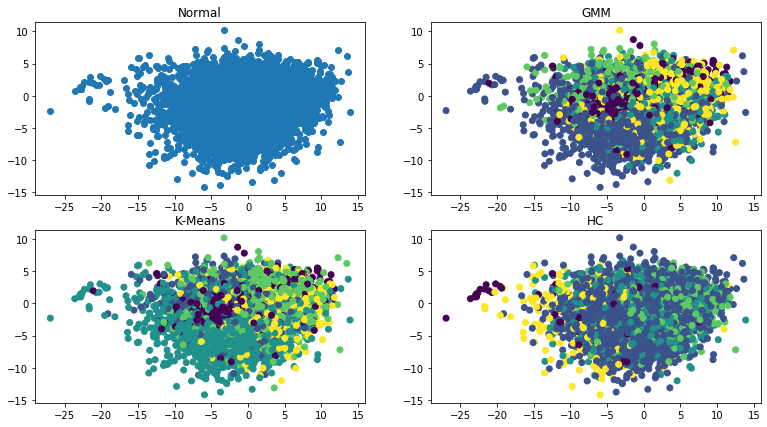

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


45
46


[[2714, 3160, 7607, 4736, 5097],
 4662.8,
 [0.24405104780791398,
  0.04447365947890816,
  0.011912228238956752,
  0.03922061745261764,
  0.020769270919702324],
 0.07208536477961977]

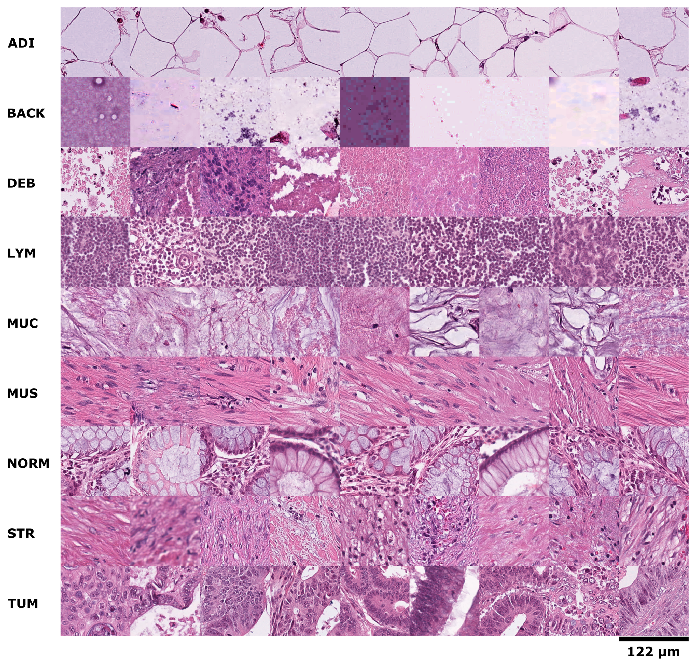

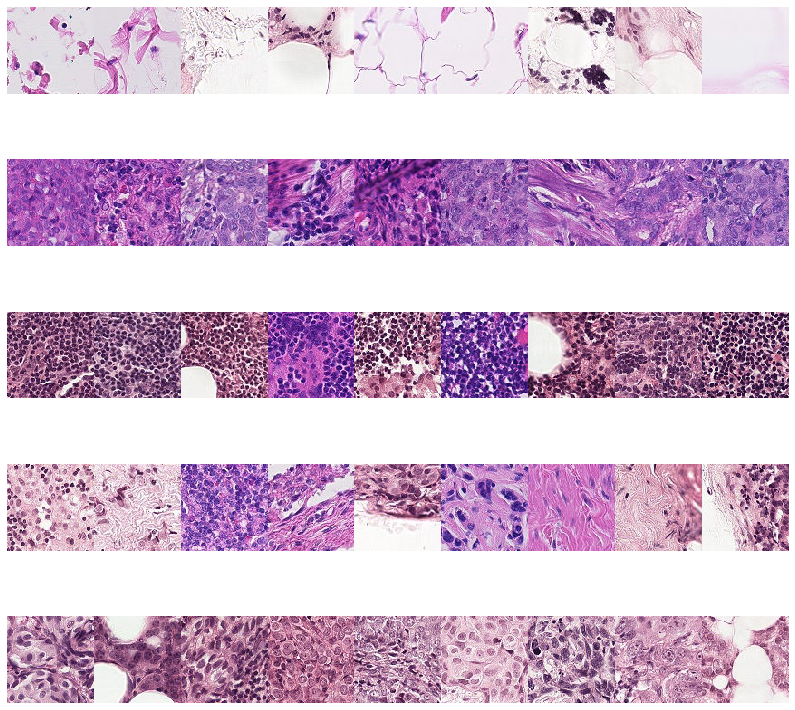

In [8]:
n_images = X.shape[0]
X = X.reshape((n_images, -1))
print(X.shape)

Labels = ClusterAndPlot(5, X)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])
valMse

In [9]:
# PCA 
pca = PCA(n_components=0.85)
transformedData = pca.fit_transform(X)
pca.n_components_

114

(9999, 114)
HC Silhouette Score  0.06654846668243408 
kmeans Silhouette Score  0.13127420842647552 
gmm Silhouette Score  0.09440013021230698 


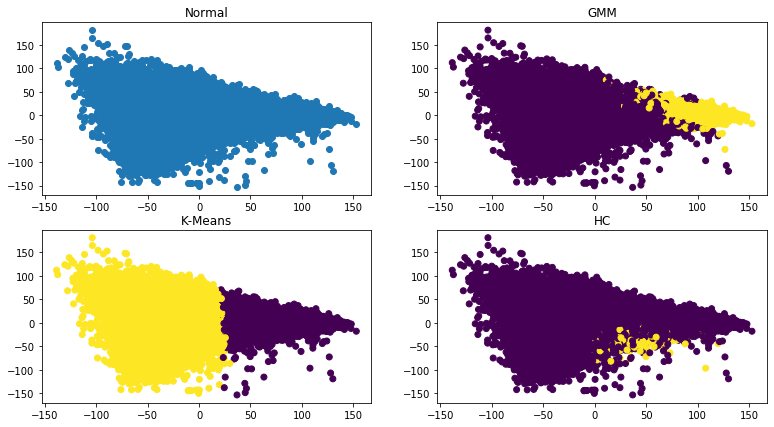

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


18
19


[[2538, 5409],
 3973.5,
 [0.15560247433643226, 0.023022770482610047],
 0.08931262240952115]

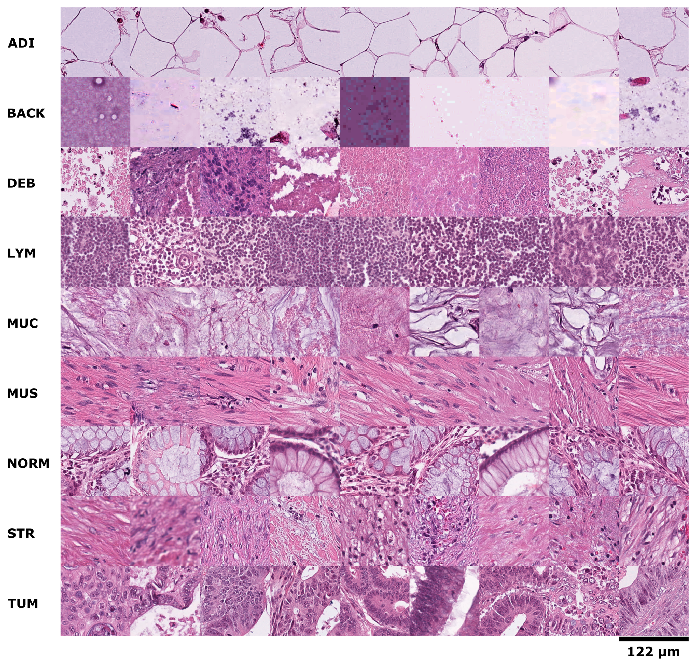

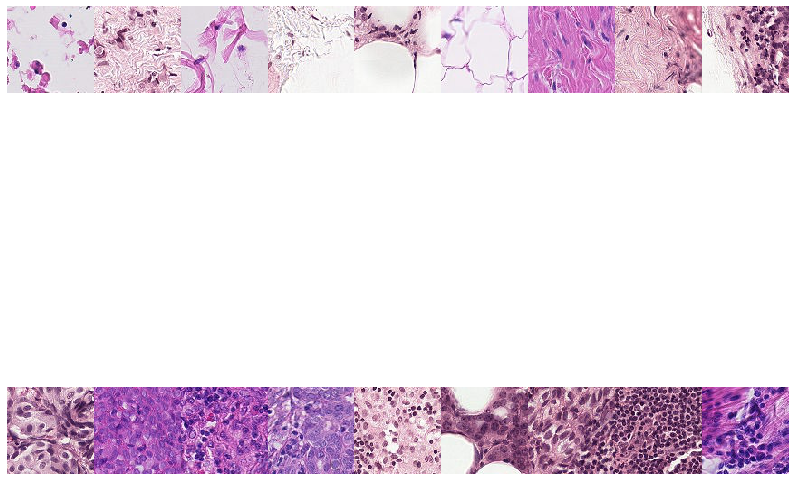

In [10]:
Labels = ClusterAndPlot(2, transformedData)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])
valMse

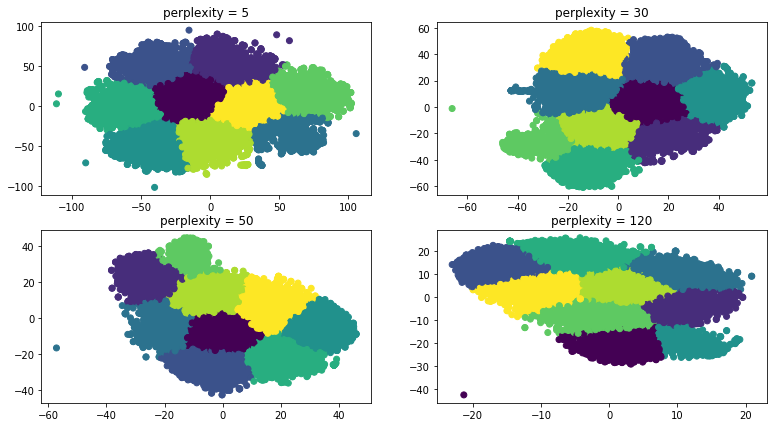

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7))

tsne1 = TSNE(n_components=2, perplexity = 5).fit_transform(transformedData)
kmeans1 = KMeans(n_clusters=9).fit(tsne1)

axs[0, 0].scatter(tsne1[:, 0], tsne1[:, 1], c=kmeans1.labels_, cmap='viridis')
axs[0, 0].set_title('perplexity = 5')

tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(transformedData)
kmeans2 = KMeans(n_clusters=9).fit(tsne2)

axs[0, 1].scatter(tsne2[:, 0], tsne2[:, 1], c=kmeans2.labels_, cmap='viridis')
axs[0, 1].set_title('perplexity = 30')

tsne3 = TSNE(n_components=2, perplexity = 50).fit_transform(transformedData)
kmeans3 = KMeans(n_clusters=9).fit(tsne3)
axs[1, 0].scatter(tsne3[:, 0], tsne3[:, 1], c=kmeans3.labels_, cmap='viridis')
axs[1, 0].set_title('perplexity = 50')

tsne4 = TSNE(n_components=2, perplexity = 120).fit_transform(transformedData)
kmeans4 = KMeans(n_clusters=9).fit(tsne4)

axs[1, 1].scatter(tsne4[:, 0], tsne4[:, 1], c=kmeans4.labels_, cmap='viridis')
axs[1, 1].set_title('perplexity = 120')
plt.show()